# EF3M Implementation Testing
## Abstract
This notebook tests the implementation of the EF3M algorithm using synthetic data as well as the example used in the source literature. This notebook is intended to provide convincing evidence of the accuracy of this EF3M implementation.
## Introduction
The Exact Fit of the first 3 Moments (EF3M) algorithm allows the parameters of a mixture of Gaussian distributions to be estimated given the first 5 moments of the mixture distribution, as well as the assumption that the mixture distribution is composed of a number of Gaussian distributions. The algorithm, its development, and its original implementation are described in López de Prado, M. and M. Foreman (2014): "A mixture of Gaussians approach to mathematical portfolio oversight: The EF3M algorithm." _Quantitative Finance_, Vol. 14, No. 5, pp. 913-930. The implementation tested here can be found in the `EF3M\ef3m.py` module located in this directory of the repository. Three test cases are presented. First, the example from the algorithm's source paper is presented to confirm that we can replicate the results of literature. Second, a user-defined mixture of 2 Gaussian distributions is generated and the EF3M implementation is tasked to recover the original mixture parameters from the raw moments of the synthetic distribution. Third, the second case is executed using a series of randomly chosen parameters from which to compose the mixture distribution. The notebook user can alter this at will but should keep in mind that running a large number of trials with hundreds or thousands of rounds each will take hours or days even using the current multiprocessing implementation.
## Conclusion
The tests run in this notebook conclude that using the EF3M algorithm to generate a series of estimates followed by a kernel density estimation to determine the most likely value for each parameter from said series results in a recovery of the original mixture parameters to within a very close tolerance. There appear to be at least two central solutions when fitting a mixture of two Gaussians, but both solutions appear to reproduce the mixture distribution, thus both can be considered viable and correct solutions in the absence of further evidence. 
## Next Steps
The implementation tested here supports only distributions assumed to be composed of two Gaussian distributions. A natural next step would be to extend this algorithm to $n$ Gaussian distributions. This implementation would take exponentially more computing power but may prove useful in more complex mixtures. Additionally, extending or encapsulating these methods to make use of a distributed computing resource would greatly speed up simulations that consist of more than 1000 fits.

----
----
## Test Cases
Test cases and accompanying code are described below. The next cell sets up some helper functions for the below analysis.

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, moment
from IPython.display import display

# import function from our custom module
from mlfinlab.bet_sizing.ef3m import M2N, raw_moment, most_likely_parameters


def mixture_samples(params, n=10_000):
    # returns 'n' samples from a mixture distribution defined by 'params'
    # :param params: (list) mixture parameters [mu1, mu2, sigma1, sigma2, p1]
    # :param n: (int) number of samples to draw
    # :return: (numpy.array) an array of the length 'n' of distribution mixture samples
    # ===================================================
    n1 = int(n*params[4])
    n2 = n - n1
    d1 = np.random.normal(params[0], params[2], n1)
    d2 = np.random.normal(params[1], params[3], n2)
    return np.concatenate((d1, d2))

def plot_fit(true_list, fit_list, n=10_000):
    # plots the true and fit mixture distributions
    # :param true_list: (list) true parameters [mu1, mu2, sigma1, sigma2, p1]
    # :param fit_list: (list) true parameters [mu1, mu2, sigma1, sigma2, p1]
    # :param n: (int) number of samples to draw
    # :return: (None)
    # ===================================================
    d_true = mixture_samples(true_list, n)
    d_fit = mixture_samples(fit_list, n)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.distplot(d_true, kde=True, bins=200, ax=ax, label=f'True Mixture Distribution {true_list}')
    sns.distplot(d_fit, kde=True, bins=200, ax=ax, label=f'Fitted Mixture Distribution {fit_list}')
    ax.legend(loc='upper left')
    plt.show()
    return None


----
### Case 1: Example data from source literature
López de Prado, M. and M. Foreman (2014): "A mixture of Gaussians approach to mathematical portfolio oversight: The EF3M algorithm." _Quantitative Finance_, Vol. 14, No. 5, pp. 913-930. The below cell calculates the raw moments from the sample distribution parameters, $(-2, 1, 2, 1, \frac{1}{10})$, as a demonstration of the helper functions. 

In [2]:
# moments and parameters from source literature
true_params = [-2, 1, 2, 1, 0.1]

true_samples = mixture_samples(true_params, n=1_000_000)

# calculate the central moments
mmnts = [moment(true_samples, moment=i) for i in range(1, 6)]

# calculate the raw moments
raw_mmnts = raw_moment(central_moments=mmnts, dist_mean=np.mean(true_samples))

# moments caluclated from the paper
moments = [0.7, 2.6, 0.4, 25, -59.8]

# let's look at the moments
display(pd.DataFrame.from_dict({'Moment': [f'E[r^{i+1}]' for i, m in enumerate(mmnts)],
                                'From paper': moments,
                                'Central (about mean)': mmnts,
                                'Raw (about origin)': raw_mmnts,
                                'Significance': ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Hyperskewness']}))

,Moment,From paper,Central (about mean),Raw (about origin),Significance
0,E[r^1],0.7,0.000000,0.698571,Mean
1,E[r^2],2.6,2.103636,2.591638,Variance
2,E[r^3],0.4,-4.335228,0.414295,Skewness
3,E[r^4],25.0,30.597509,24.881260,Kurtosis
4,E[r^5],-59.8,-152.416961,-59.362506,Hyperskewness


The cell below executes a number of fits and collects the results into a table of the most likely parameters (using a kernel density estimation), and the average and standard deviation of the difference between the true value and fit values from each fitting run. The cell after this plots the distributions generated from the true and most likely parameters as an ultimate comparison of the fit. It is especially useful in instances where the most likely set of fitted parameters is one of the multiple solutions that does not exactly match the true parameters.

In [3]:
# 20_000 runs takes approx. 4h30min (Intel i7-7700K)

n_runs = 100
epsilon = 10**-6
factor = 5

m2n = M2N(moments, epsilon=epsilon, factor=factor, n_runs=n_runs, variant=2, max_iter=10_000_000)
df2 = m2n.mp_fit()
df2 = df2.sort_values('error')
results = most_likely_parameters(df2)

# setup comparison DataFrame
para_cols = ['mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'p_1']

for ei, pcol in enumerate(para_cols):
    df2[pcol+'_err'] = true_params[ei] - df2[pcol]

df_results_case1 = pd.DataFrame.from_dict({'Parameter': ['mu1', 'mu2', 'sigma1', 'sigma2', 'p1'],
                                           'Original': true_params,
                                           'Most Likely': list(results.values()),
                                           'Deviation Average': [df2[col].mean() for col in [p+'_err' for p in para_cols]],
                                           'Deviation StDev': [df2[col].std() for col in [p+'_err' for p in para_cols]]})

display(df_results_case1)

|#########################| Completed 100 of 100 fitting rounds.

,Parameter,Original,Most Likely,Deviation Average,Deviation StDev
0,mu1,-2.0,-1.69680,-0.161222,0.238506
1,mu2,1.0,1.01222,-0.005101,0.009568
2,sigma1,2.0,2.09269,-0.048320,0.073684
3,sigma2,1.0,0.98585,0.008304,0.011429
4,p1,0.1,0.11503,-0.008417,0.011748


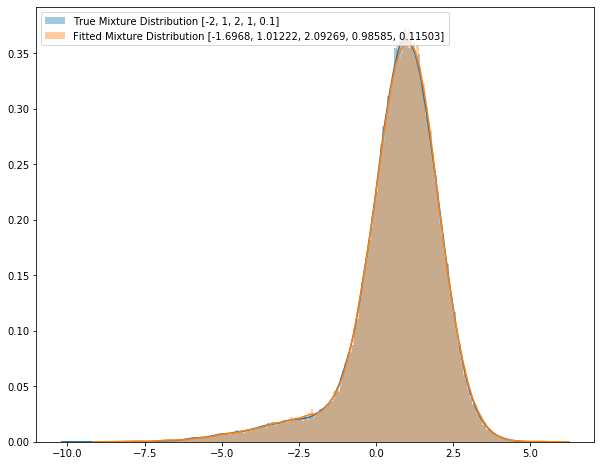

In [4]:
# plot the distributions generated from the true and most likely parameters
plot_fit(true_params, list(results.values()), n=100_000)

----
### Case 2: User-defined single example
Define the parameters of the two Gaussian distributions to mix in the cell below.

In [5]:
# setup user sample
mu1 = -1
mu2 = 4
sigma1 = 2
sigma2 = 1.5
p1 = 0.45

Below we generate the mixture, and then calculate the central moments (using `scipy.stats.moment`) and finally the raw momments (about the origin) as required by the EF3M algorithm.

In [6]:
# generate 10_000 samples for our custom mixture distribution
true_params = [mu1, mu2, sigma1, sigma2, p1]
true_samples = mixture_samples(true_params, n=100_000)

# calculate the central moments
mmnts = [moment(true_samples, moment=i) for i in range(1, 6)]

# calculate the raw moments
raw_mmnts = raw_moment(central_moments=mmnts, dist_mean=np.mean(true_samples))

# let's look at the moments
display(pd.DataFrame.from_dict({'Moment':[f'E[r^{i+1}]' for i, m in enumerate(mmnts)],
                                'Central (about mean)': mmnts,
                                'Raw (about origin)': raw_mmnts,
                                'Significance': ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Hyperskewness']}))

,Moment,Central (about mean),Raw (about origin),Significance
0,E[r^1],0.000000,1.750583,Mean
1,E[r^2],9.171495,12.236034,Variance
2,E[r^3],-9.382028,44.149077,Skewness
3,E[r^4],186.997337,299.331115,Kurtosis
4,E[r^5],-462.257325,1395.464351,Hyperskewness


Now create the M2N object and run a fit. Take a look at the top values, find the most likely values, and plot to compare the original distribution against the distribution made using the recovered parameters. Try adjusting the `n_runs`, or `epsilon` in `m2n.mpFit` to get better results. Variant 2 usually converges faster than variant 1 and typically leads to a lower error, but both are available for use.

|#########################| Completed 50 of 50 fitting rounds.

'Top values from the EF3M fit:'

,mu_1,mu_2,sigma_1,sigma_2,p_1,error
0,-0.996657,3.982753,1.99149,1.510189,0.448393,0.000606
0,-0.996657,3.982753,1.99149,1.510189,0.448393,0.000606
0,-0.996657,3.982753,1.99149,1.510189,0.448393,0.000606
0,-0.996657,3.982753,1.99149,1.510189,0.448393,0.000606
0,-0.996657,3.982753,1.99149,1.510189,0.448393,0.000606


,Original,Estimated
0,-1.00,-0.99930
1,4.00,3.98663
2,2.00,1.99095
3,1.50,1.51177
4,0.45,0.44847


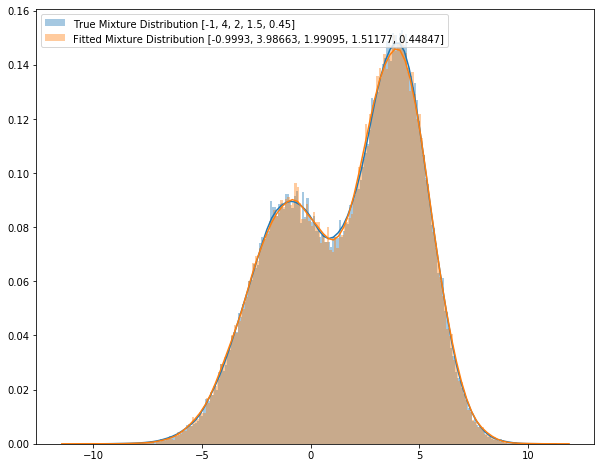

In [7]:
n_runs = 50
epsiolon = 10**-5
factor = 5

m2n = M2N(raw_mmnts, epsilon=epsilon, factor=factor, n_runs=n_runs, variant=2, max_iter=10_000_000)
df_results = m2n.mp_fit()
display("Top values from the EF3M fit:")
display(df_results.head())
results = most_likely_parameters(df_results)
display(pd.DataFrame.from_dict({'Original': true_params,
                                'Estimated': list(results.values())}))
plot_fit(true_params, list(results.values()), n=100_000)  # adjust 'n' to get a smoother distribution

----
### Case 3: Series of randomly generated examples
In López de Prado and Foreman (2014), the authors used randomly generated Gaussian mixture distributions to test that the EF3M algorithm performed well in general. The parameter tuple desribing the observed distribution, $(\tilde{\mu}_1, \tilde{\mu}_2, \tilde{\sigma}_1, \tilde{\sigma}_2, \tilde{p}_1)$, was drawn from the uniform distribution with boundaries $-1 \leq \mu_1 \leq 0 \leq \mu_2 \leq 1$, $0 < \sigma_1 \leq 1$, $0 < \sigma_2 \leq 1$, $0 < p < 1$. This is reflected in the code below. Change the number of rounds, number of fits per round, and mixture parameters to test additional scenarios. Authors used 10,000 test rounds and 10,000 fits per round, but note that running this on a single developer workstation will take days or weeks to complete, so smaller numbers are advised.

In [8]:

test_rounds = 5  # number of random tests to conduct
fit_runs = 10  # M2N fitting rouns per round
epsiolon = 10**-5
factor = 5

# define parameter ranges, (low, high)
mu1_range = (-1, 0)
mu2_range = (0, 1)
sigma1_range = (1e-5, 1)
sigma2_range = (1e-5, 1)
p1_range = (1e-5, 1-1e-5)

param_ranges = [mu1_range, mu2_range, sigma1_range, sigma2_range, p1_range]
true_collection, fit_collection = [], []
mu1_err, mu2_err, sigma1_err, sigma2_err, p1_err = [], [], [], [], []
m1_err, m2_err, m3_err, m4_err, m5_err = [], [], [], [], []

for round_i in range(test_rounds):
    true_params = [np.random.uniform(r[0], r[1]) for r in param_ranges]  # generate random parameters
    true_samples = mixture_samples(true_params, n=10_000)
    mmnts = [moment(true_samples, moment=i) for i in range(1, 6)]  # calculate the central moments
    raw_mmnts = raw_moment(central_moments=mmnts, dist_mean=np.mean(true_samples))  # calculate the raw moments
    m2n = M2N(raw_mmnts, epsilon=epsilon, factor=factor, n_runs=fit_runs, variant=2, max_iter=10_000_000)
    df_results = m2n.mp_fit()
    results = list(most_likely_parameters(df_results).values())
    fit_mmnts = m2n.get_moments(results, return_result=True)
    
    # store results
    true_collection.append(true_params)
    fit_collection.append(results)
    
    # store parameter deviations
    for ai, a_err in enumerate([mu1_err, mu2_err, sigma1_err, sigma2_err, p1_err]):
        a_err.append(true_params[ai] - results[ai])
    
    # store moment deviation
    for bi, m_err in enumerate([m1_err, m2_err, m3_err, m4_err, m5_err]):
        m_err.append(mmnts[bi] - fit_mmnts[bi])
    

df_collection = pd.DataFrame.from_dict({'Original': true_collection,
                                        'Fit': fit_collection,
                                        'mu1_err': mu1_err, 'mu2_err': mu2_err, 'sigma1_err': sigma1_err, 'sigma2_err': sigma2_err, 'p1_err': p1_err,
                                        'm1_err': m1_err, 'm2_err': m2_err, 'm3_err': m3_err, 'm4_err': m4_err, 'm5_err': m5_err})

err_cols = ['mu1_err', 'mu2_err', 'sigma1_err', 'sigma2_err', 'p1_err']
m_cols = ['m1_err', 'm2_err', 'm3_err', 'm4_err', 'm5_err']

df_results_case2 = pd.DataFrame.from_dict({'Errors': [1, 2, 3, 4, 5],
                                           'Errors Average': [df_collection[col].mean() for col in m_cols],
                                           'Errors StDev': [df_collection[col].std() for col in m_cols],
                                           'Deviation': ['mu1', 'mu2', 'sigma1', 'sigma2', 'p1'],
                                           'Deviation Average': [df_collection[col].mean() for col in err_cols],
                                           'Deviation StDev': [df_collection[col].std() for col in err_cols]})

print("Compare results to Figure 4 in López de Prado and Foreman (2014)")
display(df_results_case2)

|####################     | Completed 8 of 10 fitting rounds..

Compare results to Figure 4 in López de Prado and Foreman (2014)


|#########################| Completed 10 of 10 fitting rounds.

,Errors,Errors Average,Errors StDev,Deviation,Deviation Average,Deviation StDev
0,1,-0.142448,0.351780,mu1,0.152870,0.223704
1,2,-0.120292,0.118920,mu2,0.012942,0.045486
2,3,-0.356041,1.024131,sigma1,0.068488,0.093474
3,4,-0.037676,0.265383,sigma2,0.000443,0.028409
4,5,-2.380061,5.935656,p1,0.016094,0.036002
